In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"triikas","key":"f14377df34f4e726878188c3afc64058"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d esmanurdeli/scooby-doo-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/esmanurdeli/scooby-doo-classification-dataset
License(s): CC0-1.0
  0% 0.00/2.31M [00:00<?, ?B/s]
100% 2.31M/2.31M [00:00<00:00, 180MB/s]


In [ ]:
import shutil
shutil.unpack_archive("/content/scooby-doo-classification-dataset.zip",
                      "/content/scooby-doo-classification-dataset")

In [ ]:
datadir='/content/scooby-doo-classification-dataset/dataset'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as T
from IPython.display import Image
from skimage import io
from torchvision.utils import make_grid

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
batch_size=32

In [ ]:
transform = T.Compose([
    T.Resize([128,128]),
    T.ToTensor(),
])


dataset = datasets.ImageFolder(datadir, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


mean = torch.zeros(3)
std = torch.zeros(3)
total_images = 0

for images, _ in loader:
    batch_samples = images.size(0)  # Количество изображений в батче
    images = images.view(batch_samples, 3, -1)  # Переформатируем в (batch, 3, пиксели)

    mean += images.mean(dim=[0, 2])  # Среднее по каждому каналу
    std += images.std(dim=[0, 2])    # Стандартное отклонение по каждому каналу
    total_images += batch_samples

mean /= total_images
std /= total_images
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.0157, 0.0145, 0.0131])
Std: tensor([0.0110, 0.0102, 0.0105])


In [ ]:
transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=30),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.Resize([128,128]),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

In [ ]:
transform = T.Compose([ # для тр
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset=datasets.ImageFolder(datadir,transform=transform)
len(dataset)

221

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [191, 30])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [ ]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

torch.Size([32, 3, 128, 128])


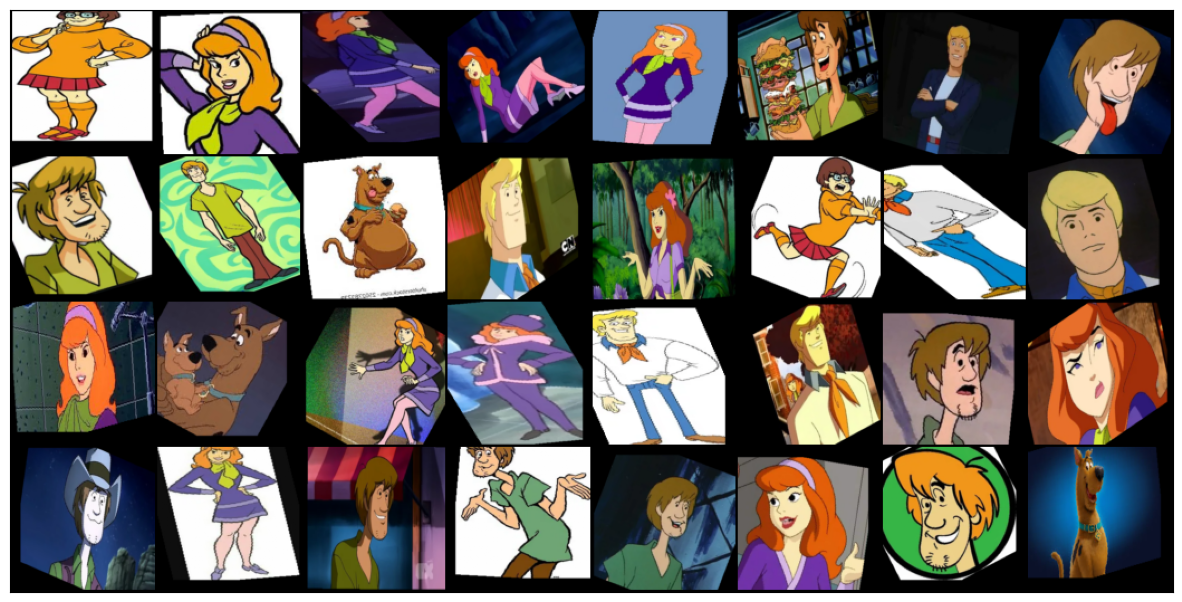

In [ ]:
show_batch(train_loader) # до нормализации

torch.Size([32, 3, 128, 128])


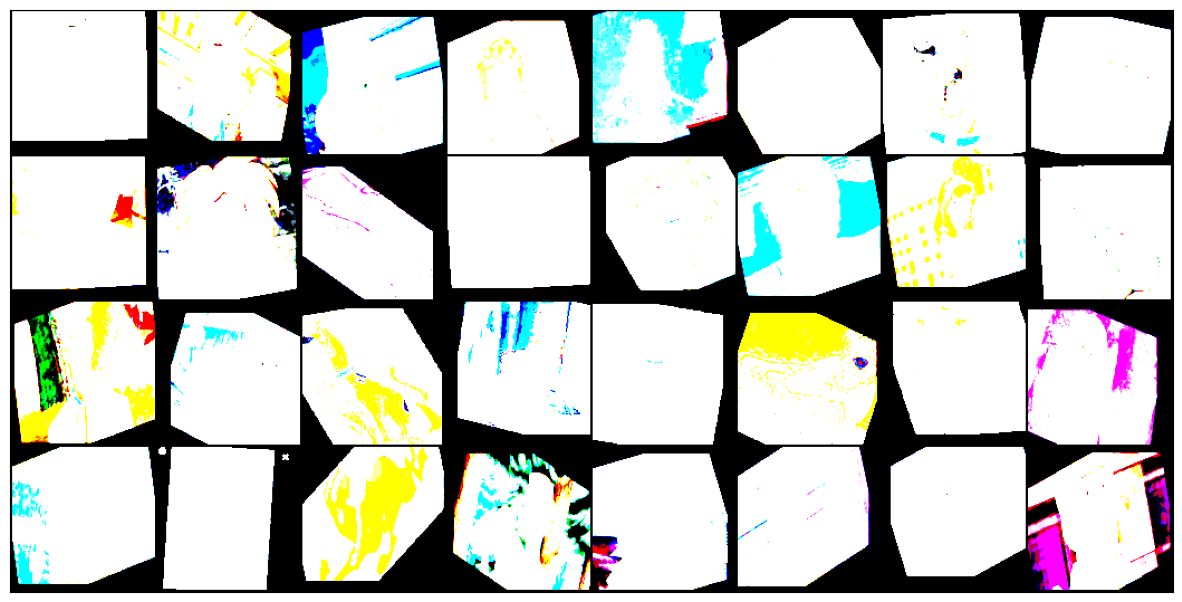

In [ ]:
show_batch(train_loader) # после нормализации

In [ ]:
"""
Модель 1
"""

class M1(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))

        x = x.view(-1, 64 * 32 * 32)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)

        return x

model = M1()
model.to(device)

M1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

In [ ]:
"""
Модель 2
"""

class M2(nn.Module):
    def __init__(self):
        super(M2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2, padding=1)
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(512*9*9, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 5)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool4(x)
        print(x.shape)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x


model = M2()
model.to(device)

M2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start

In [ ]:
"""
Модель 3
"""

class M3(nn.Module):
    def __init__(self):
        super(M3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(512*8*8, 256)
        # self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 5)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = self.pool3(x)

        x = F.relu(self.conv7(x))
        x = self.pool4(x)
        print(x.shape)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x


model = M3()
model.to(device)

M3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=5, bias=True)
)

In [ ]:
"""
Модель 4
"""

class M4(nn.Module):
    def __init__(self):
        super(M4, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(512*8*8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 5)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = self.pool3(x)

        x = F.relu(self.conv7(x))
        x = self.pool4(x)
        print(x.shape)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x


model = M4()
model.to(device)

M4(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=

In [ ]:
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    output = model(images)

In [ ]:
!pip install pytorch-ignite --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.8 MB/s eta 0:00:00


In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [ ]:
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=5)}

In [ ]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [ ]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [ ]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [ ]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

In [ ]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 23.39 Сред. ошибка: 1.70888
Результат валидации - Эпоха: 1  Сред. точность: 24.00 Сред. ошибка: 1.63532


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 19.88 Сред. ошибка: 1.58143
Результат валидации - Эпоха: 2  Сред. точность: 26.00 Сред. ошибка: 1.58492


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 26.90 Сред. ошибка: 1.59001
Результат валидации - Эпоха: 3  Сред. точность: 28.00 Сред. ошибка: 1.60583


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 22.81 Сред. ошибка: 1.59143
Результат валидации - Эпоха: 4  Сред. точность: 22.00 Сред. ошибка: 1.61295


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 21.64 Сред. ошибка: 1.60235
Результат валидации - Эпоха: 5  Сред. точность: 26.00 Сред. ошибка: 1.61228


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 29.82 Сред. ошибка: 1.57787
Результат валидации - Эпоха: 6  Сред. точность: 22.00 Сред. ошибка: 1.59300


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 25.73 Сред. ошибка: 1.58259
Результат валидации - Эпоха: 7  Сред. точность: 18.00 Сред. ошибка: 1.58061


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 23.39 Сред. ошибка: 1.58505
Результат валидации - Эпоха: 8  Сред. точность: 26.00 Сред. ошибка: 1.57204


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 26.32 Сред. ошибка: 1.56989
Результат валидации - Эпоха: 9  Сред. точность: 18.00 Сред. ошибка: 1.56739


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 28.65 Сред. ошибка: 1.57769
Результат валидации - Эпоха: 10  Сред. точность: 20.00 Сред. ошибка: 1.58482


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 24.56 Сред. ошибка: 1.56896
Результат валидации - Эпоха: 11  Сред. точность: 28.00 Сред. ошибка: 1.58829


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 26.32 Сред. ошибка: 1.56277
Результат валидации - Эпоха: 12  Сред. точность: 20.00 Сред. ошибка: 1.58411


 17%|#6        | 1/6 [00:00<?, ?it/s]

2025-03-16 22:07:24,099 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Результат обучения - Эпоха: 13  Сред. точность: 25.15 Сред. ошибка: 1.56363
Результат валидации - Эпоха: 13  Сред. точность: 18.00 Сред. ошибка: 1.60129


2025-03-16 22:07:24,276 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 78
	epoch: 13
	epoch_length: 6
	max_epochs: 15
	output: 1.6063004732131958
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

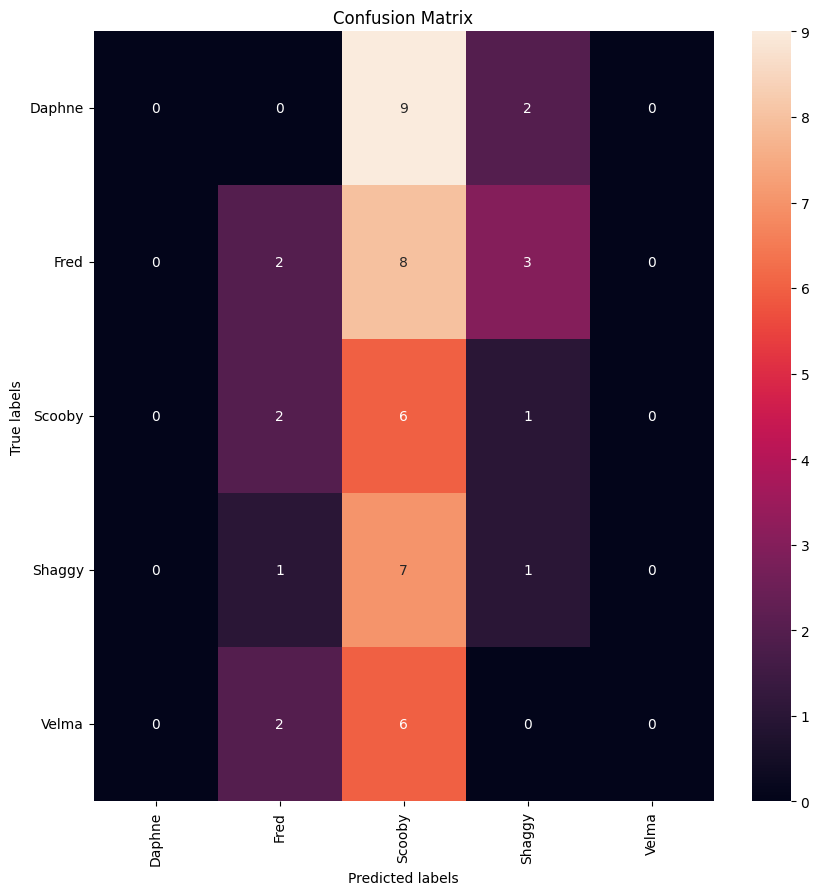

In [ ]:
trainer.run(train_loader, max_epochs=15)

State:
	iteration: 90
	epoch: 15
	epoch_length: 6
	max_epochs: 15
	output: 1.7156134843826294
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

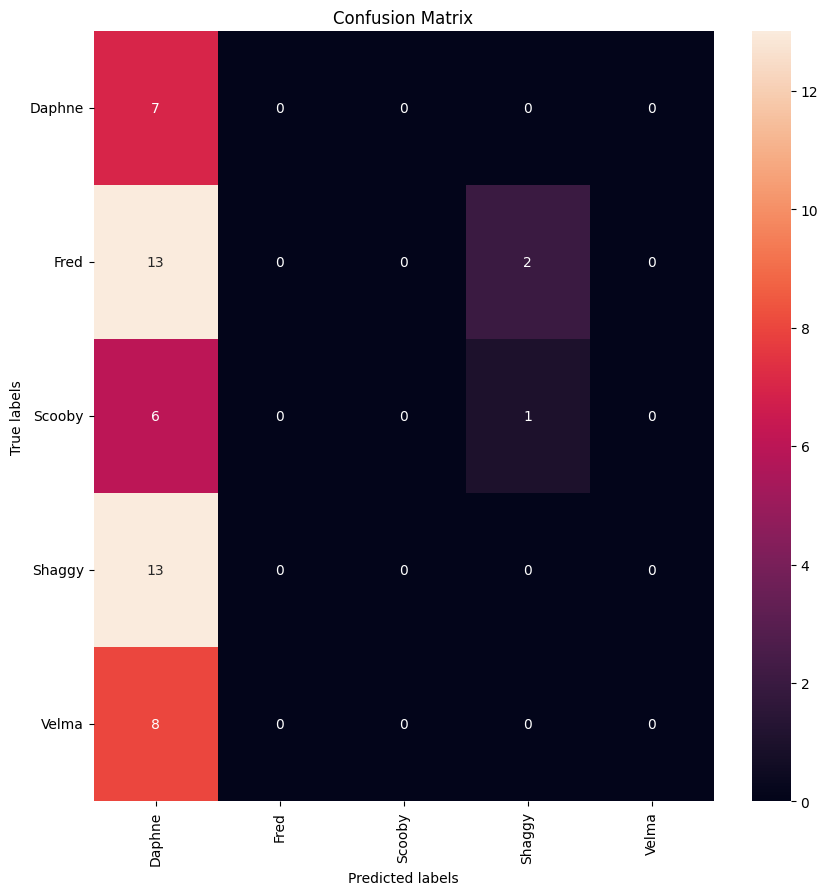

In [ ]:
trainer.run(train_loader, max_epochs=15) # модель 1

torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 1  Сред. точность: 23.56 Сред. ошибка: 1.58535
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 1  Сред. точность: 10.00 Сред. ошибка: 1.62761
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 2  Сред. точность: 23.04 Сред. ошибка: 1.57559
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 2  Сред. точность: 23.33 Сред. ошибка: 1.63080
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 3  Сред. точность: 26.70 Сред. ошибка: 1.57358
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 3  Сред. точность: 23.33 Сред. ошибка: 1.64327
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 4  Сред. точность: 23.56 Сред. ошибка: 1.57548
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 4  Сред. точность: 20.00 Сред. ошибка: 1.61508
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 5  Сред. точность: 30.89 Сред. ошибка: 1.55833
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 5  Сред. точность: 33.33 Сред. ошибка: 1.59744
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 6  Сред. точность: 24.61 Сред. ошибка: 1.56418
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 6  Сред. точность: 20.00 Сред. ошибка: 1.66260
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 7  Сред. точность: 31.41 Сред. ошибка: 1.54079
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 7  Сред. точность: 20.00 Сред. ошибка: 1.60364
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 8  Сред. точность: 29.32 Сред. ошибка: 1.50267
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 8  Сред. точность: 33.33 Сред. ошибка: 1.58487
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 9  Сред. точность: 29.84 Сред. ошибка: 1.55567
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 9  Сред. точность: 23.33 Сред. ошибка: 1.59724
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 10  Сред. точность: 30.37 Сред. ошибка: 1.54530
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 10  Сред. точность: 26.67 Сред. ошибка: 1.58937
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 11  Сред. точность: 26.18 Сред. ошибка: 1.55874
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 11  Сред. точность: 23.33 Сред. ошибка: 1.58487
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 12  Сред. точность: 28.80 Сред. ошибка: 1.52461
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 12  Сред. точность: 23.33 Сред. ошибка: 1.57734
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 13  Сред. точность: 32.98 Сред. ошибка: 1.48671
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 13  Сред. точность: 26.67 Сред. ошибка: 1.56389
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 14  Сред. точность: 38.22 Сред. ошибка: 1.42430
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 14  Сред. точность: 26.67 Сред. ошибка: 1.51085
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 15  Сред. точность: 38.74 Сред. ошибка: 1.39314


2025-03-16 23:03:47,854 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
2025-03-16 23:03:47,991 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 15  Сред. точность: 33.33 Сред. ошибка: 1.48836
torch.Size([30, 512, 9, 9])


State:
	iteration: 90
	epoch: 15
	epoch_length: 6
	max_epochs: 25
	output: 1.4191267490386963
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

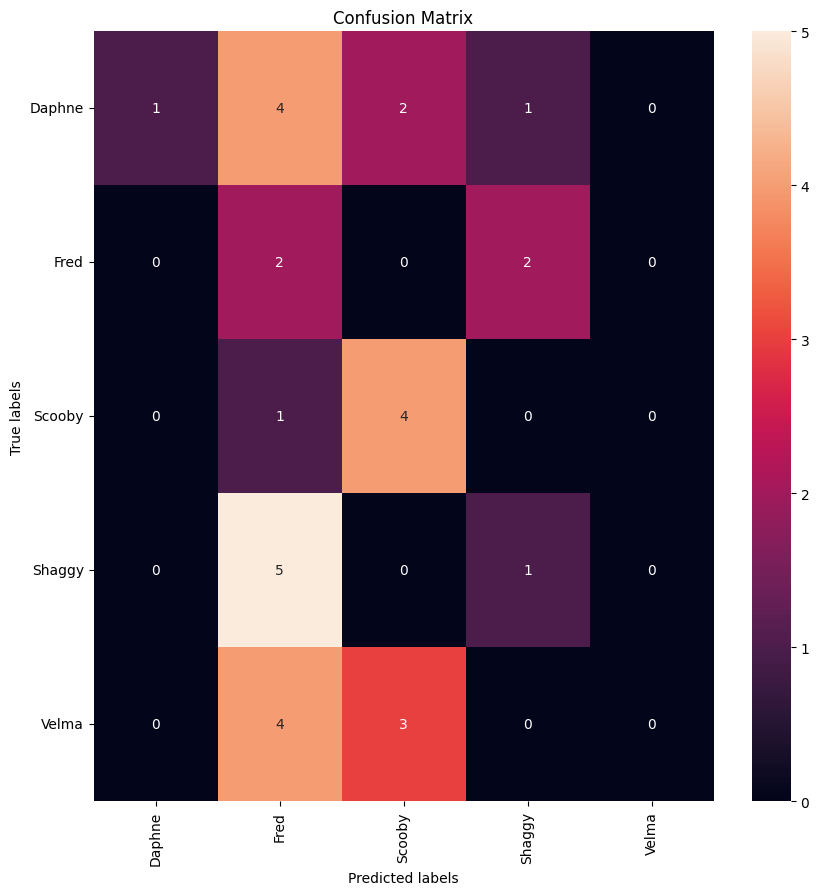

In [ ]:
trainer.run(train_loader, max_epochs=25) # модель 2 в1

torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 1  Сред. точность: 21.47 Сред. ошибка: 1.60990
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 1  Сред. точность: 16.67 Сред. ошибка: 1.61029
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 2  Сред. точность: 29.32 Сред. ошибка: 1.63103
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 2  Сред. точность: 26.67 Сред. ошибка: 1.76698
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 3  Сред. точность: 23.56 Сред. ошибка: 1.60006
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 3  Сред. точность: 16.67 Сред. ошибка: 1.61846
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 4  Сред. точность: 24.08 Сред. ошибка: 1.58249
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 4  Сред. точность: 16.67 Сред. ошибка: 1.65585
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 5  Сред. точность: 23.56 Сред. ошибка: 1.57552
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 5  Сред. точность: 16.67 Сред. ошибка: 1.65748
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 6  Сред. точность: 23.56 Сред. ошибка: 1.59436
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 6  Сред. точность: 16.67 Сред. ошибка: 1.60042
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 7  Сред. точность: 23.56 Сред. ошибка: 1.58344
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 7  Сред. точность: 16.67 Сред. ошибка: 1.63487
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 8  Сред. точность: 23.56 Сред. ошибка: 1.56091
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 8  Сред. точность: 16.67 Сред. ошибка: 1.59561
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 9  Сред. точность: 24.08 Сред. ошибка: 1.49887
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 9  Сред. точность: 16.67 Сред. ошибка: 1.59422
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 10  Сред. точность: 33.51 Сред. ошибка: 1.51032
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 10  Сред. точность: 43.33 Сред. ошибка: 1.53178
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 11  Сред. точность: 36.65 Сред. ошибка: 1.40297
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 11  Сред. точность: 43.33 Сред. ошибка: 1.42915
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 12  Сред. точность: 39.79 Сред. ошибка: 1.35709
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 12  Сред. точность: 33.33 Сред. ошибка: 1.39994
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 13  Сред. точность: 43.46 Сред. ошибка: 1.23914
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 13  Сред. точность: 43.33 Сред. ошибка: 1.50994
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 14  Сред. точность: 49.21 Сред. ошибка: 1.13667
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 14  Сред. точность: 36.67 Сред. ошибка: 1.32325
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 15  Сред. точность: 51.83 Сред. ошибка: 1.09887
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 15  Сред. точность: 36.67 Сред. ошибка: 1.60974
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 16  Сред. точность: 49.74 Сред. ошибка: 1.20894
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 16  Сред. точность: 53.33 Сред. ошибка: 1.21557
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 17  Сред. точность: 60.73 Сред. ошибка: 0.97020
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 17  Сред. точность: 50.00 Сред. ошибка: 1.60902
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 18  Сред. точность: 64.40 Сред. ошибка: 1.11145
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 18  Сред. точность: 66.67 Сред. ошибка: 1.32995
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 19  Сред. точность: 72.25 Сред. ошибка: 0.71639
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 19  Сред. точность: 40.00 Сред. ошибка: 1.41463
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 20  Сред. точность: 67.54 Сред. ошибка: 0.97846
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 20  Сред. точность: 36.67 Сред. ошибка: 2.48604
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 21  Сред. точность: 76.96 Сред. ошибка: 0.61980
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 21  Сред. точность: 53.33 Сред. ошибка: 3.79274
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 22  Сред. точность: 84.82 Сред. ошибка: 0.43550
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 22  Сред. точность: 60.00 Сред. ошибка: 1.79083
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 23  Сред. точность: 90.05 Сред. ошибка: 0.33326
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 23  Сред. точность: 60.00 Сред. ошибка: 2.97876
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 24  Сред. точность: 94.24 Сред. ошибка: 0.20677
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 24  Сред. точность: 60.00 Сред. ошибка: 0.98379
torch.Size([32, 512, 9, 9])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([32, 512, 9, 9])
torch.Size([31, 512, 9, 9])
Результат обучения - Эпоха: 25  Сред. точность: 87.96 Сред. ошибка: 0.30200
torch.Size([30, 512, 9, 9])
Результат валидации - Эпоха: 25  Сред. точность: 66.67 Сред. ошибка: 1.27302
torch.Size([30, 512, 9, 9])


State:
	iteration: 150
	epoch: 25
	epoch_length: 6
	max_epochs: 25
	output: 0.18528935313224792
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

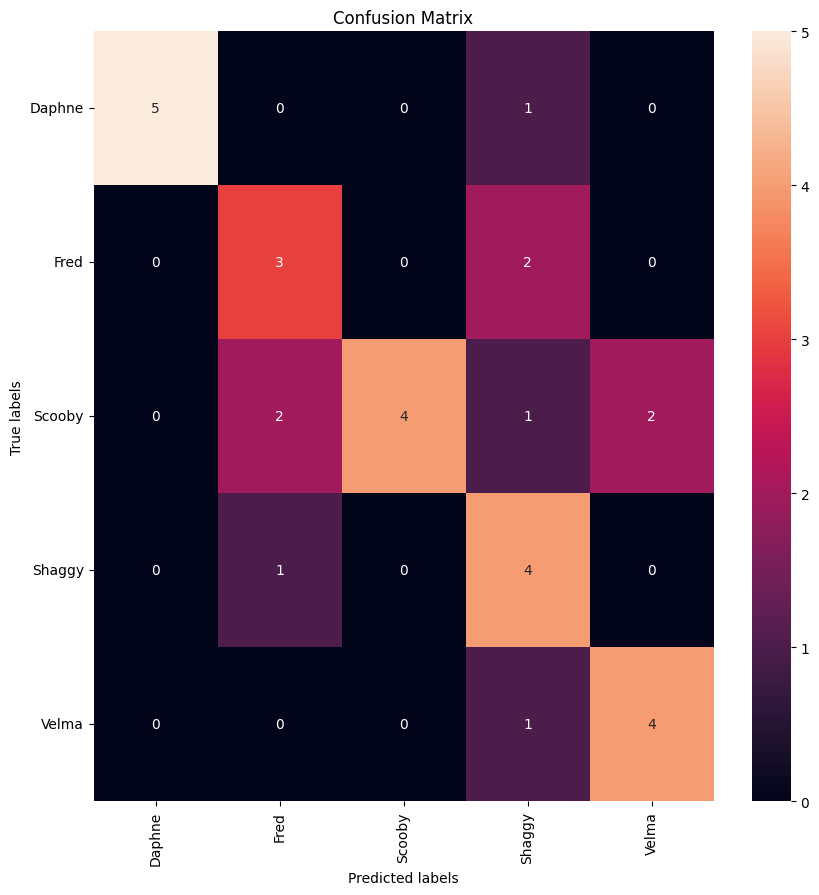

In [ ]:
trainer.run(train_loader, max_epochs=25) # модель 2 в2

 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 22.51 Сред. ошибка: 1.60076
Результат валидации - Эпоха: 1  Сред. точность: 23.33 Сред. ошибка: 1.60737


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 22.51 Сред. ошибка: 1.58343
Результат валидации - Эпоха: 2  Сред. точность: 23.33 Сред. ошибка: 1.59771


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 22.51 Сред. ошибка: 1.55933
Результат валидации - Эпоха: 3  Сред. точность: 23.33 Сред. ошибка: 1.56059


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 30.37 Сред. ошибка: 1.54996
Результат валидации - Эпоха: 4  Сред. точность: 20.00 Сред. ошибка: 1.54323


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 27.23 Сред. ошибка: 1.57082
Результат валидации - Эпоха: 5  Сред. точность: 36.67 Сред. ошибка: 1.53243


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 35.60 Сред. ошибка: 1.50188
Результат валидации - Эпоха: 6  Сред. точность: 50.00 Сред. ошибка: 1.46954


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 47.12 Сред. ошибка: 1.21018
Результат валидации - Эпоха: 7  Сред. точность: 56.67 Сред. ошибка: 1.24939


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 60.21 Сред. ошибка: 1.00100
Результат валидации - Эпоха: 8  Сред. точность: 60.00 Сред. ошибка: 1.42455


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 53.40 Сред. ошибка: 1.04432
Результат валидации - Эпоха: 9  Сред. точность: 46.67 Сред. ошибка: 1.40297


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 64.40 Сред. ошибка: 1.01712
Результат валидации - Эпоха: 10  Сред. точность: 56.67 Сред. ошибка: 1.21160


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 74.87 Сред. ошибка: 0.65051
Результат валидации - Эпоха: 11  Сред. точность: 63.33 Сред. ошибка: 1.45220


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 76.44 Сред. ошибка: 0.60309
Результат валидации - Эпоха: 12  Сред. точность: 63.33 Сред. ошибка: 1.42661


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 85.34 Сред. ошибка: 0.43040
Результат валидации - Эпоха: 13  Сред. точность: 70.00 Сред. ошибка: 1.49596


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 74.35 Сред. ошибка: 0.49672
Результат валидации - Эпоха: 14  Сред. точность: 56.67 Сред. ошибка: 2.27661


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 79.06 Сред. ошибка: 0.55000
Результат валидации - Эпоха: 15  Сред. точность: 56.67 Сред. ошибка: 2.04875


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 86.39 Сред. ошибка: 0.39113
Результат валидации - Эпоха: 16  Сред. точность: 53.33 Сред. ошибка: 2.15177


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 86.39 Сред. ошибка: 0.32435
Результат валидации - Эпоха: 17  Сред. точность: 60.00 Сред. ошибка: 1.61894


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 91.10 Сред. ошибка: 0.26392
Результат валидации - Эпоха: 18  Сред. точность: 70.00 Сред. ошибка: 1.49608


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 95.81 Сред. ошибка: 0.12190
Результат валидации - Эпоха: 19  Сред. точность: 63.33 Сред. ошибка: 2.45595


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 97.91 Сред. ошибка: 0.07577
Результат валидации - Эпоха: 20  Сред. точность: 60.00 Сред. ошибка: 3.78898


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 98.95 Сред. ошибка: 0.05852
Результат валидации - Эпоха: 21  Сред. точность: 56.67 Сред. ошибка: 4.45443


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 98.43 Сред. ошибка: 0.04981
Результат валидации - Эпоха: 22  Сред. точность: 60.00 Сред. ошибка: 4.29675


 17%|#6        | 1/6 [00:00<?, ?it/s]

2025-03-16 23:37:42,740 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Результат обучения - Эпоха: 23  Сред. точность: 95.81 Сред. ошибка: 0.19772
Результат валидации - Эпоха: 23  Сред. точность: 66.67 Сред. ошибка: 4.37159


2025-03-16 23:37:42,869 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 138
	epoch: 23
	epoch_length: 6
	max_epochs: 25
	output: 0.8322321176528931
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

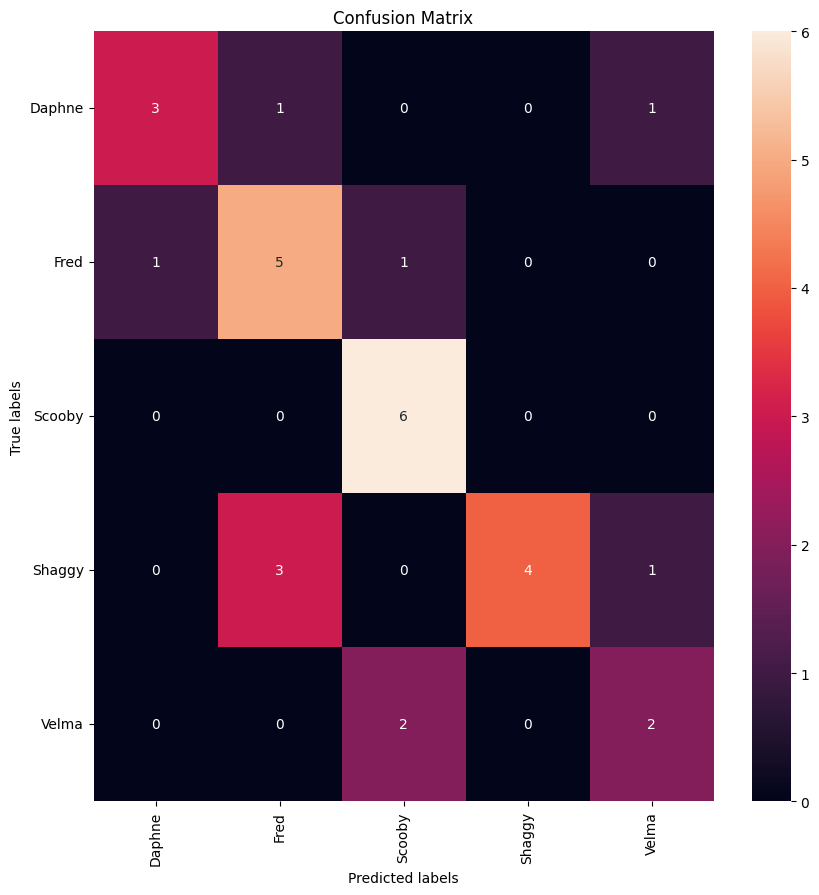

In [ ]:
trainer.run(train_loader, max_epochs=25) # модель 2 в3

 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 24.61 Сред. ошибка: 1.59728
Результат валидации - Эпоха: 1  Сред. точность: 13.33 Сред. ошибка: 1.60859


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 24.61 Сред. ошибка: 1.59831
Результат валидации - Эпоха: 2  Сред. точность: 13.33 Сред. ошибка: 1.61328


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 24.61 Сред. ошибка: 1.64140
Результат валидации - Эпоха: 3  Сред. точность: 13.33 Сред. ошибка: 1.65816


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 30.37 Сред. ошибка: 1.56894
Результат валидации - Эпоха: 4  Сред. точность: 26.67 Сред. ошибка: 1.58797


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 29.84 Сред. ошибка: 1.54076
Результат валидации - Эпоха: 5  Сред. точность: 23.33 Сред. ошибка: 1.59891


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 47.12 Сред. ошибка: 1.45779
Результат валидации - Эпоха: 6  Сред. точность: 33.33 Сред. ошибка: 1.52134


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 38.22 Сред. ошибка: 1.46563
Результат валидации - Эпоха: 7  Сред. точность: 30.00 Сред. ошибка: 1.64758


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 51.83 Сред. ошибка: 1.24360
Результат валидации - Эпоха: 8  Сред. точность: 40.00 Сред. ошибка: 1.19785


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 50.79 Сред. ошибка: 1.18154
Результат валидации - Эпоха: 9  Сред. точность: 40.00 Сред. ошибка: 1.22273


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 53.40 Сред. ошибка: 1.16338
Результат валидации - Эпоха: 10  Сред. точность: 50.00 Сред. ошибка: 1.12745


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 54.45 Сред. ошибка: 1.06403
Результат валидации - Эпоха: 11  Сред. точность: 40.00 Сред. ошибка: 1.13343


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 63.35 Сред. ошибка: 0.98540
Результат валидации - Эпоха: 12  Сред. точность: 43.33 Сред. ошибка: 1.15414


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 70.16 Сред. ошибка: 0.77876
Результат валидации - Эпоха: 13  Сред. точность: 53.33 Сред. ошибка: 1.01955


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 66.49 Сред. ошибка: 0.81249
Результат валидации - Эпоха: 14  Сред. точность: 46.67 Сред. ошибка: 1.00256


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 63.87 Сред. ошибка: 0.76923
Результат валидации - Эпоха: 15  Сред. точность: 46.67 Сред. ошибка: 1.15427


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 74.35 Сред. ошибка: 0.71918
Результат валидации - Эпоха: 16  Сред. точность: 56.67 Сред. ошибка: 1.26279


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 75.92 Сред. ошибка: 0.62460
Результат валидации - Эпоха: 17  Сред. точность: 53.33 Сред. ошибка: 1.30463


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 79.06 Сред. ошибка: 0.48770
Результат валидации - Эпоха: 18  Сред. точность: 53.33 Сред. ошибка: 1.18971


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 82.20 Сред. ошибка: 0.49872
Результат валидации - Эпоха: 19  Сред. точность: 50.00 Сред. ошибка: 1.37324


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 72.25 Сред. ошибка: 0.65112
Результат валидации - Эпоха: 20  Сред. точность: 53.33 Сред. ошибка: 1.45760


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 71.20 Сред. ошибка: 0.67860
Результат валидации - Эпоха: 21  Сред. точность: 73.33 Сред. ошибка: 0.72636


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 76.96 Сред. ошибка: 0.57001
Результат валидации - Эпоха: 22  Сред. точность: 60.00 Сред. ошибка: 1.22855


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 74.87 Сред. ошибка: 0.62365
Результат валидации - Эпоха: 23  Сред. точность: 66.67 Сред. ошибка: 0.97227


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 77.49 Сред. ошибка: 0.68805
Результат валидации - Эпоха: 24  Сред. точность: 53.33 Сред. ошибка: 1.25532


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 83.25 Сред. ошибка: 0.43426
Результат валидации - Эпоха: 25  Сред. точность: 60.00 Сред. ошибка: 1.30499


State:
	iteration: 150
	epoch: 25
	epoch_length: 6
	max_epochs: 25
	output: 0.5462621450424194
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

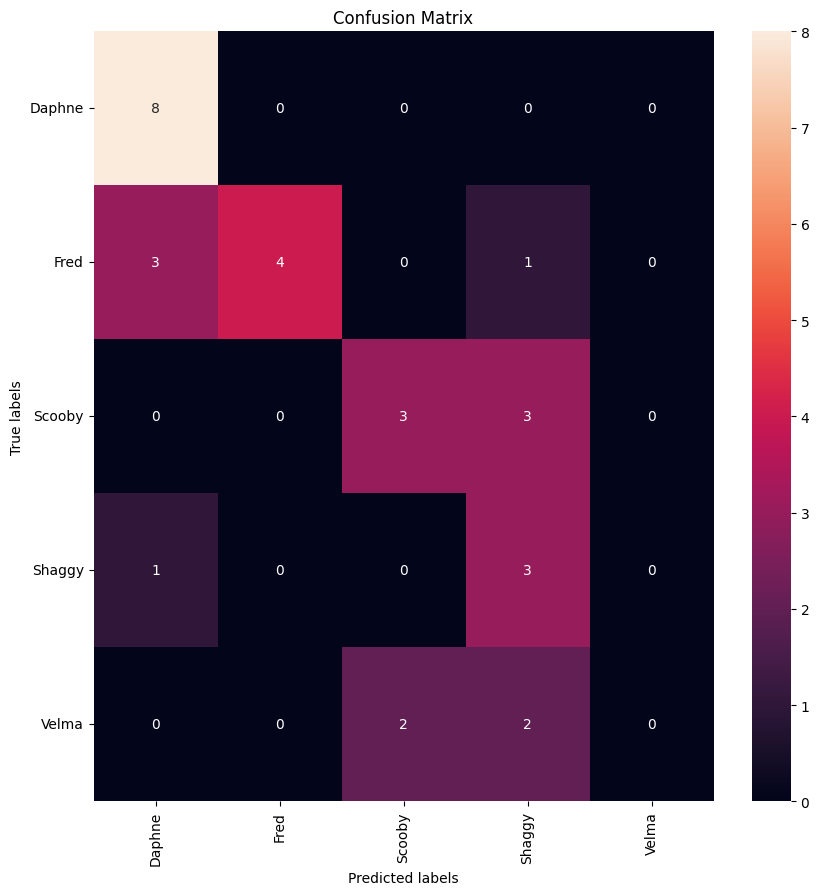

In [ ]:
trainer.run(train_loader, max_epochs=25) # модель 2 в4

torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 1  Сред. точность: 20.42 Сред. ошибка: 1.59742
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 1  Сред. точность: 36.67 Сред. ошибка: 1.57566
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 2  Сред. точность: 26.18 Сред. ошибка: 1.57633
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 2  Сред. точность: 13.33 Сред. ошибка: 1.54912
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 3  Сред. точность: 25.65 Сред. ошибка: 1.52828
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 3  Сред. точность: 16.67 Сред. ошибка: 1.46001
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 4  Сред. точность: 37.17 Сред. ошибка: 1.34052
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 4  Сред. точность: 30.00 Сред. ошибка: 1.32072
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 5  Сред. точность: 54.97 Сред. ошибка: 1.07202
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 5  Сред. точность: 33.33 Сред. ошибка: 1.28718
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 6  Сред. точность: 66.49 Сред. ошибка: 0.94527
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 6  Сред. точность: 53.33 Сред. ошибка: 1.25113
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 7  Сред. точность: 73.30 Сред. ошибка: 0.72369
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 7  Сред. точность: 70.00 Сред. ошибка: 0.88231
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 8  Сред. точность: 76.96 Сред. ошибка: 0.56017
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 8  Сред. точность: 53.33 Сред. ошибка: 1.16833
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 9  Сред. точность: 81.68 Сред. ошибка: 0.51310
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 9  Сред. точность: 53.33 Сред. ошибка: 1.08665
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 10  Сред. точность: 85.34 Сред. ошибка: 0.32488
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 10  Сред. точность: 80.00 Сред. ошибка: 1.02932
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 11  Сред. точность: 93.72 Сред. ошибка: 0.20001
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 11  Сред. точность: 70.00 Сред. ошибка: 0.93039
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 12  Сред. точность: 96.86 Сред. ошибка: 0.13786
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 12  Сред. точность: 73.33 Сред. ошибка: 2.02009
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 13  Сред. точность: 90.58 Сред. ошибка: 0.18277
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 13  Сред. точность: 63.33 Сред. ошибка: 1.42395
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 14  Сред. точность: 95.81 Сред. ошибка: 0.13806
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 14  Сред. точность: 73.33 Сред. ошибка: 1.92316
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 15  Сред. точность: 95.29 Сред. ошибка: 0.10726
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 15  Сред. точность: 83.33 Сред. ошибка: 1.36767
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 16  Сред. точность: 97.91 Сред. ошибка: 0.04146
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 16  Сред. точность: 63.33 Сред. ошибка: 1.46421
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 17  Сред. точность: 99.48 Сред. ошибка: 0.01640
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 17  Сред. точность: 76.67 Сред. ошибка: 1.30909
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 18  Сред. точность: 98.43 Сред. ошибка: 0.02742
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 18  Сред. точность: 73.33 Сред. ошибка: 1.42334
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 19  Сред. точность: 96.86 Сред. ошибка: 0.07787
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 19  Сред. точность: 73.33 Сред. ошибка: 1.12898
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 20  Сред. точность: 97.91 Сред. ошибка: 0.08400
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 20  Сред. точность: 63.33 Сред. ошибка: 2.11889
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 21  Сред. точность: 100.00 Сред. ошибка: 0.01331
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 21  Сред. точность: 86.67 Сред. ошибка: 1.69715
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 22  Сред. точность: 100.00 Сред. ошибка: 0.01006
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 22  Сред. точность: 76.67 Сред. ошибка: 1.38594
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 23  Сред. точность: 99.48 Сред. ошибка: 0.02553
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 23  Сред. точность: 80.00 Сред. ошибка: 1.72967
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 24  Сред. точность: 100.00 Сред. ошибка: 0.01960
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 24  Сред. точность: 73.33 Сред. ошибка: 1.73211
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 25  Сред. точность: 98.95 Сред. ошибка: 0.01492
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 25  Сред. точность: 80.00 Сред. ошибка: 2.63096
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 26  Сред. точность: 99.48 Сред. ошибка: 0.00905
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 26  Сред. точность: 73.33 Сред. ошибка: 1.95074
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 27  Сред. точность: 100.00 Сред. ошибка: 0.00169
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 27  Сред. точность: 76.67 Сред. ошибка: 2.34909
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 28  Сред. точность: 100.00 Сред. ошибка: 0.00141
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 28  Сред. точность: 76.67 Сред. ошибка: 2.57500
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 29  Сред. точность: 99.48 Сред. ошибка: 0.02859
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 29  Сред. точность: 73.33 Сред. ошибка: 3.58449
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 30  Сред. точность: 92.67 Сред. ошибка: 0.23882
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 30  Сред. точность: 76.67 Сред. ошибка: 2.31444
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 31  Сред. точность: 89.01 Сред. ошибка: 0.30172


2025-03-16 23:59:37,152 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
2025-03-16 23:59:37,290 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 31  Сред. точность: 70.00 Сред. ошибка: 2.44952
torch.Size([30, 512, 8, 8])


State:
	iteration: 186
	epoch: 31
	epoch_length: 6
	max_epochs: 35
	output: 0.032775864005088806
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

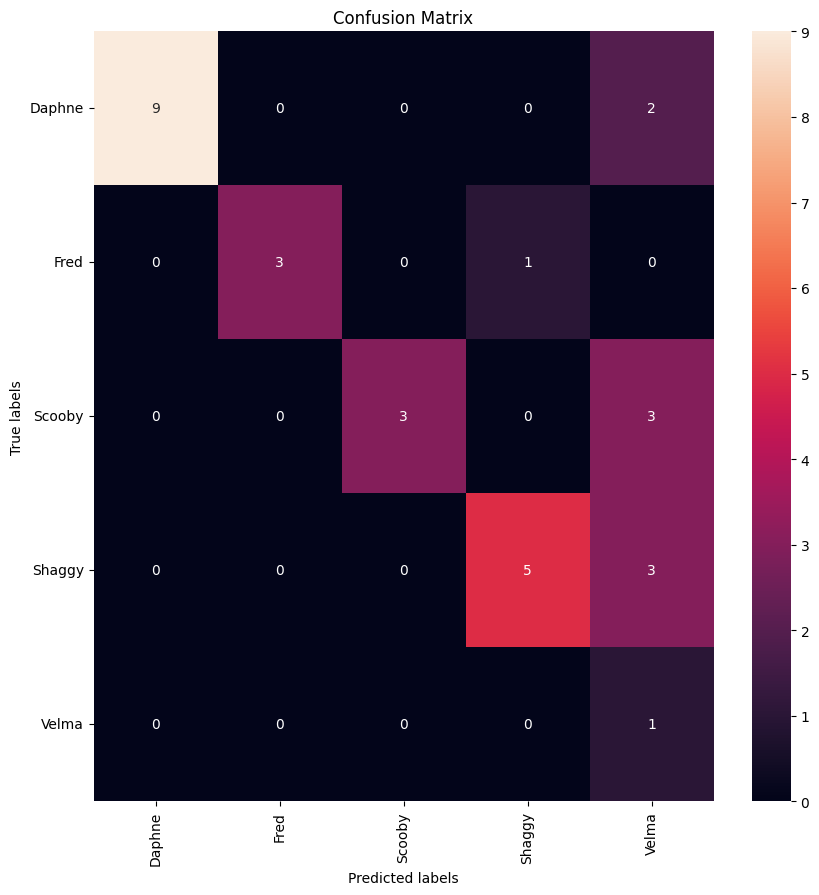

In [ ]:
trainer.run(train_loader, max_epochs=35) # модель 3

torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 1  Сред. точность: 24.08 Сред. ошибка: 1.60247
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 1  Сред. точность: 26.67 Сред. ошибка: 1.59522
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 2  Сред. точность: 23.56 Сред. ошибка: 1.59283
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 2  Сред. точность: 16.67 Сред. ошибка: 1.60632
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 3  Сред. точность: 26.70 Сред. ошибка: 1.56542
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 3  Сред. точность: 16.67 Сред. ошибка: 1.58765
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 4  Сред. точность: 45.55 Сред. ошибка: 1.32471
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 4  Сред. точность: 40.00 Сред. ошибка: 1.59673
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 5  Сред. точность: 52.36 Сред. ошибка: 1.18232
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 5  Сред. точность: 33.33 Сред. ошибка: 1.82593
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 6  Сред. точность: 58.12 Сред. ошибка: 0.94502
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 6  Сред. точность: 46.67 Сред. ошибка: 1.36771
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 7  Сред. точность: 68.06 Сред. ошибка: 0.87767
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 7  Сред. точность: 40.00 Сред. ошибка: 1.40354
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 8  Сред. точность: 76.44 Сред. ошибка: 0.64873
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 8  Сред. точность: 46.67 Сред. ошибка: 1.37620
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 9  Сред. точность: 84.82 Сред. ошибка: 0.58666
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 9  Сред. точность: 46.67 Сред. ошибка: 1.46264
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 10  Сред. точность: 87.43 Сред. ошибка: 0.34819
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 10  Сред. точность: 46.67 Сред. ошибка: 1.20199
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 11  Сред. точность: 92.15 Сред. ошибка: 0.27777
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 11  Сред. точность: 53.33 Сред. ошибка: 1.63499
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 12  Сред. точность: 94.24 Сред. ошибка: 0.17067
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 12  Сред. точность: 63.33 Сред. ошибка: 1.80640
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 13  Сред. точность: 98.43 Сред. ошибка: 0.06259
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 13  Сред. точность: 66.67 Сред. ошибка: 1.58323
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 14  Сред. точность: 95.29 Сред. ошибка: 0.12983
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 14  Сред. точность: 70.00 Сред. ошибка: 1.54640
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 15  Сред. точность: 96.34 Сред. ошибка: 0.08939
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 15  Сред. точность: 56.67 Сред. ошибка: 2.23882
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 16  Сред. точность: 87.96 Сред. ошибка: 0.28851
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 16  Сред. точность: 63.33 Сред. ошибка: 1.37006
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 17  Сред. точность: 94.76 Сред. ошибка: 0.27370
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 17  Сред. точность: 70.00 Сред. ошибка: 1.05275
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 18  Сред. точность: 96.34 Сред. ошибка: 0.13784
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 18  Сред. точность: 63.33 Сред. ошибка: 1.11701
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 19  Сред. точность: 98.95 Сред. ошибка: 0.05906
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 19  Сред. точность: 76.67 Сред. ошибка: 1.20085
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 20  Сред. точность: 99.48 Сред. ошибка: 0.02705
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 20  Сред. точность: 73.33 Сред. ошибка: 1.78026
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 21  Сред. точность: 100.00 Сред. ошибка: 0.01847
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 21  Сред. точность: 73.33 Сред. ошибка: 1.97345
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 22  Сред. точность: 100.00 Сред. ошибка: 0.00802
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 22  Сред. точность: 73.33 Сред. ошибка: 1.99043
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 23  Сред. точность: 100.00 Сред. ошибка: 0.00315
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 23  Сред. точность: 70.00 Сред. ошибка: 2.08734
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 24  Сред. точность: 100.00 Сред. ошибка: 0.00125
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 24  Сред. точность: 70.00 Сред. ошибка: 2.38699
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 25  Сред. точность: 100.00 Сред. ошибка: 0.00068
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 25  Сред. точность: 70.00 Сред. ошибка: 2.65616
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 26  Сред. точность: 100.00 Сред. ошибка: 0.00039
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 26  Сред. точность: 70.00 Сред. ошибка: 2.86115
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 27  Сред. точность: 100.00 Сред. ошибка: 0.00021
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 27  Сред. точность: 66.67 Сред. ошибка: 3.07720
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 28  Сред. точность: 100.00 Сред. ошибка: 0.00014
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 28  Сред. точность: 66.67 Сред. ошибка: 3.23315
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])


2025-03-17 00:09:56,947 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 29  Сред. точность: 100.00 Сред. ошибка: 0.00009
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 29  Сред. точность: 66.67 Сред. ошибка: 3.27679


2025-03-17 00:09:57,049 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


torch.Size([30, 512, 8, 8])


State:
	iteration: 174
	epoch: 29
	epoch_length: 6
	max_epochs: 35
	output: 9.883702296065167e-05
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

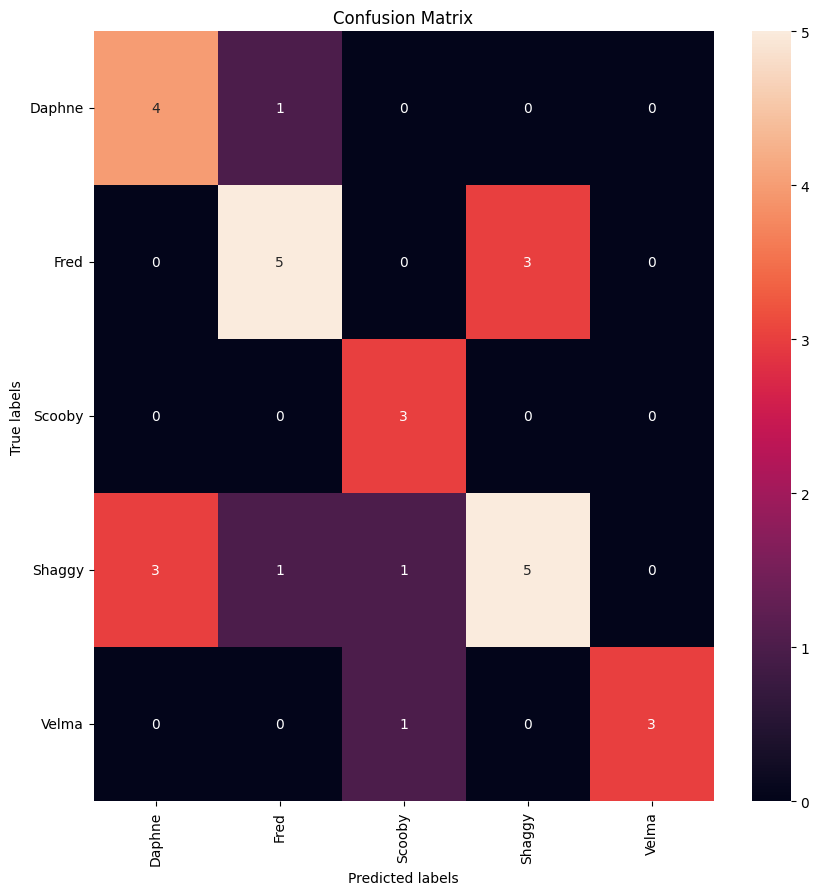

In [ ]:
trainer.run(train_loader, max_epochs=35) # модель 3 в2

torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 1  Сред. точность: 27.23 Сред. ошибка: 1.61103
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 1  Сред. точность: 13.33 Сред. ошибка: 1.69167
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 2  Сред. точность: 24.08 Сред. ошибка: 1.62526
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 2  Сред. точность: 13.33 Сред. ошибка: 1.76414
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 3  Сред. точность: 23.56 Сред. ошибка: 1.60595
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 3  Сред. точность: 20.00 Сред. ошибка: 1.59264
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 4  Сред. точность: 23.56 Сред. ошибка: 1.59308
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 4  Сред. точность: 20.00 Сред. ошибка: 1.59713
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 5  Сред. точность: 34.03 Сред. ошибка: 1.52094
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 5  Сред. точность: 20.00 Сред. ошибка: 1.60618
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 6  Сред. точность: 36.13 Сред. ошибка: 1.41958
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 6  Сред. точность: 26.67 Сред. ошибка: 1.58019
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 7  Сред. точность: 49.74 Сред. ошибка: 1.27733
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 7  Сред. точность: 33.33 Сред. ошибка: 1.53950
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 8  Сред. точность: 48.17 Сред. ошибка: 1.23548
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 8  Сред. точность: 40.00 Сред. ошибка: 1.50996
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 9  Сред. точность: 49.21 Сред. ошибка: 1.22706
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 9  Сред. точность: 33.33 Сред. ошибка: 1.82365
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 10  Сред. точность: 64.40 Сред. ошибка: 0.96764
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 10  Сред. точность: 43.33 Сред. ошибка: 1.40625
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 11  Сред. точность: 74.35 Сред. ошибка: 0.75586
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 11  Сред. точность: 46.67 Сред. ошибка: 1.91823
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 12  Сред. точность: 84.29 Сред. ошибка: 0.46669
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 12  Сред. точность: 56.67 Сред. ошибка: 1.55924
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 13  Сред. точность: 85.34 Сред. ошибка: 0.42493
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 13  Сред. точность: 56.67 Сред. ошибка: 1.22352
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 14  Сред. точность: 85.86 Сред. ошибка: 0.40314
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 14  Сред. точность: 63.33 Сред. ошибка: 0.98023
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 15  Сред. точность: 91.62 Сред. ошибка: 0.25269
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 15  Сред. точность: 66.67 Сред. ошибка: 1.73966
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 16  Сред. точность: 94.76 Сред. ошибка: 0.17511
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 16  Сред. точность: 63.33 Сред. ошибка: 2.05565
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 17  Сред. точность: 90.05 Сред. ошибка: 0.28263
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 17  Сред. точность: 50.00 Сред. ошибка: 2.55697
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 18  Сред. точность: 85.34 Сред. ошибка: 0.35243
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 18  Сред. точность: 50.00 Сред. ошибка: 1.70917
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 19  Сред. точность: 98.95 Сред. ошибка: 0.11104
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 19  Сред. точность: 66.67 Сред. ошибка: 0.93935
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 20  Сред. точность: 95.81 Сред. ошибка: 0.13858
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 20  Сред. точность: 73.33 Сред. ошибка: 0.86693
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 21  Сред. точность: 99.48 Сред. ошибка: 0.04137
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 21  Сред. точность: 70.00 Сред. ошибка: 1.03754
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 22  Сред. точность: 99.48 Сред. ошибка: 0.02289
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 22  Сред. точность: 70.00 Сред. ошибка: 1.68976
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 23  Сред. точность: 97.91 Сред. ошибка: 0.06987
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 23  Сред. точность: 63.33 Сред. ошибка: 2.39775
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 24  Сред. точность: 99.48 Сред. ошибка: 0.00790
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 24  Сред. точность: 56.67 Сред. ошибка: 2.93568
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 25  Сред. точность: 98.95 Сред. ошибка: 0.03164
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 25  Сред. точность: 66.67 Сред. ошибка: 2.88772
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 26  Сред. точность: 92.15 Сред. ошибка: 0.15809
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 26  Сред. точность: 66.67 Сред. ошибка: 1.74419
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 27  Сред. точность: 98.43 Сред. ошибка: 0.09756
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 27  Сред. точность: 60.00 Сред. ошибка: 2.17339
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 28  Сред. точность: 99.48 Сред. ошибка: 0.02159
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 28  Сред. точность: 60.00 Сред. ошибка: 1.85788
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 29  Сред. точность: 98.43 Сред. ошибка: 0.03206
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 29  Сред. точность: 70.00 Сред. ошибка: 1.59610
torch.Size([32, 512, 8, 8])


 17%|#6        | 1/6 [00:00<?, ?it/s]

torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([31, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])
torch.Size([32, 512, 8, 8])


2025-03-17 00:16:44,671 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


torch.Size([31, 512, 8, 8])
Результат обучения - Эпоха: 30  Сред. точность: 100.00 Сред. ошибка: 0.01480
torch.Size([30, 512, 8, 8])
Результат валидации - Эпоха: 30  Сред. точность: 70.00 Сред. ошибка: 1.58231


2025-03-17 00:16:44,787 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


torch.Size([30, 512, 8, 8])


State:
	iteration: 180
	epoch: 30
	epoch_length: 6
	max_epochs: 35
	output: 0.07362433522939682
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

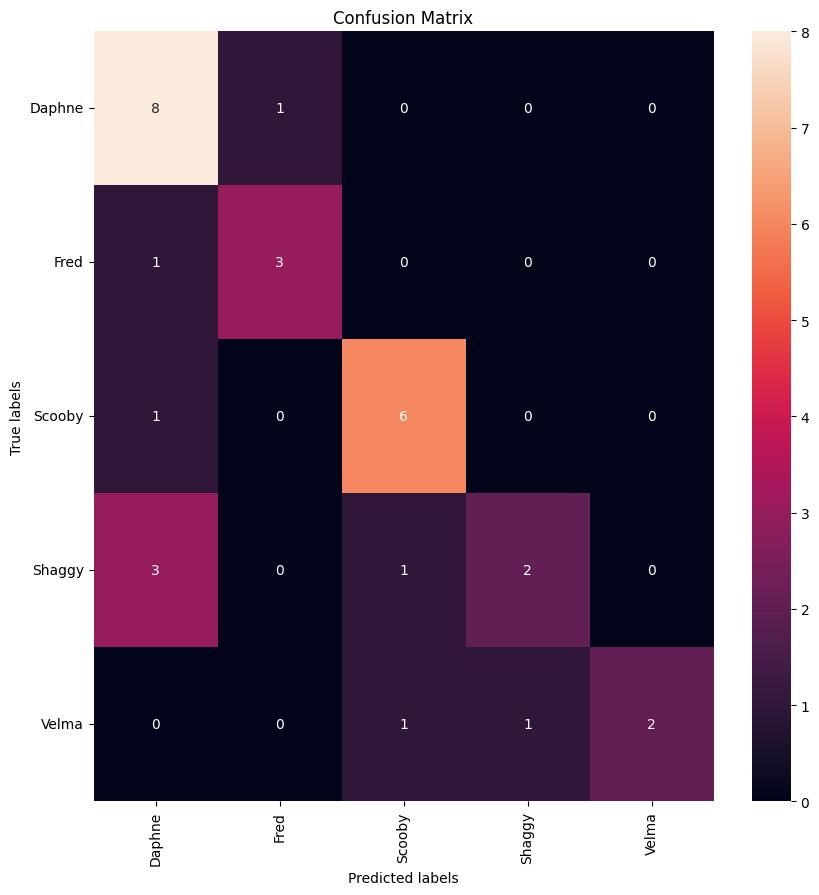

In [ ]:
trainer.run(train_loader, max_epochs=35) # модель 4

 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 70.68 Сред. ошибка: 0.72763
Результат валидации - Эпоха: 1  Сред. точность: 50.00 Сред. ошибка: 1.15014


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 96.86 Сред. ошибка: 0.10248
Результат валидации - Эпоха: 2  Сред. точность: 70.00 Сред. ошибка: 0.75865


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 100.00 Сред. ошибка: 0.01016
Результат валидации - Эпоха: 3  Сред. точность: 60.00 Сред. ошибка: 0.61334


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 100.00 Сред. ошибка: 0.00086
Результат валидации - Эпоха: 4  Сред. точность: 90.00 Сред. ошибка: 0.19266


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 100.00 Сред. ошибка: 0.00039
Результат валидации - Эпоха: 5  Сред. точность: 96.67 Сред. ошибка: 0.14942


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 100.00 Сред. ошибка: 0.00017
Результат валидации - Эпоха: 6  Сред. точность: 93.33 Сред. ошибка: 0.15089


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 100.00 Сред. ошибка: 0.00010
Результат валидации - Эпоха: 7  Сред. точность: 93.33 Сред. ошибка: 0.15812


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 100.00 Сред. ошибка: 0.00007
Результат валидации - Эпоха: 8  Сред. точность: 93.33 Сред. ошибка: 0.14268


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 100.00 Сред. ошибка: 0.00006
Результат валидации - Эпоха: 9  Сред. точность: 93.33 Сред. ошибка: 0.13280


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 100.00 Сред. ошибка: 0.00006
Результат валидации - Эпоха: 10  Сред. точность: 96.67 Сред. ошибка: 0.13216


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 100.00 Сред. ошибка: 0.00006
Результат валидации - Эпоха: 11  Сред. точность: 96.67 Сред. ошибка: 0.13108


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 100.00 Сред. ошибка: 0.00006
Результат валидации - Эпоха: 12  Сред. точность: 96.67 Сред. ошибка: 0.12742


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 100.00 Сред. ошибка: 0.00006
Результат валидации - Эпоха: 13  Сред. точность: 96.67 Сред. ошибка: 0.12521


 17%|#6        | 1/6 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 100.00 Сред. ошибка: 0.00005
Результат валидации - Эпоха: 14  Сред. точность: 96.67 Сред. ошибка: 0.12592


 17%|#6        | 1/6 [00:00<?, ?it/s]

2025-03-17 00:52:33,508 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Результат обучения - Эпоха: 15  Сред. точность: 100.00 Сред. ошибка: 0.00005
Результат валидации - Эпоха: 15  Сред. точность: 96.67 Сред. ошибка: 0.13202


2025-03-17 00:52:33,695 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 90
	epoch: 15
	epoch_length: 6
	max_epochs: 35
	output: 0.00010669155017239973
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

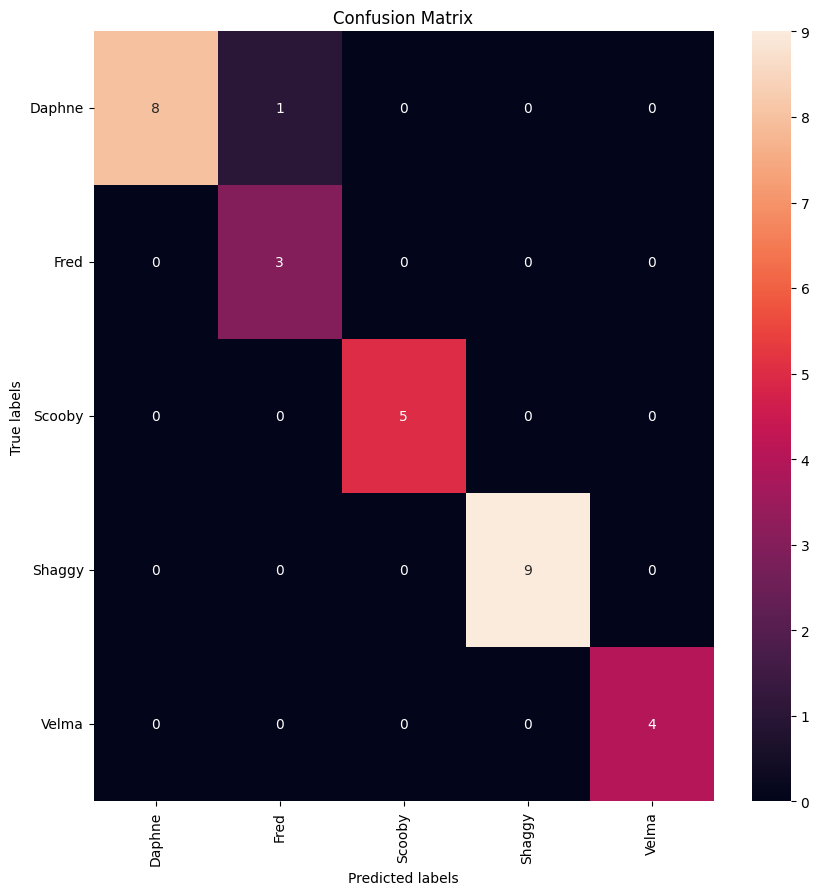

In [ ]:
trainer.run(train_loader, max_epochs=35) # модель 5000

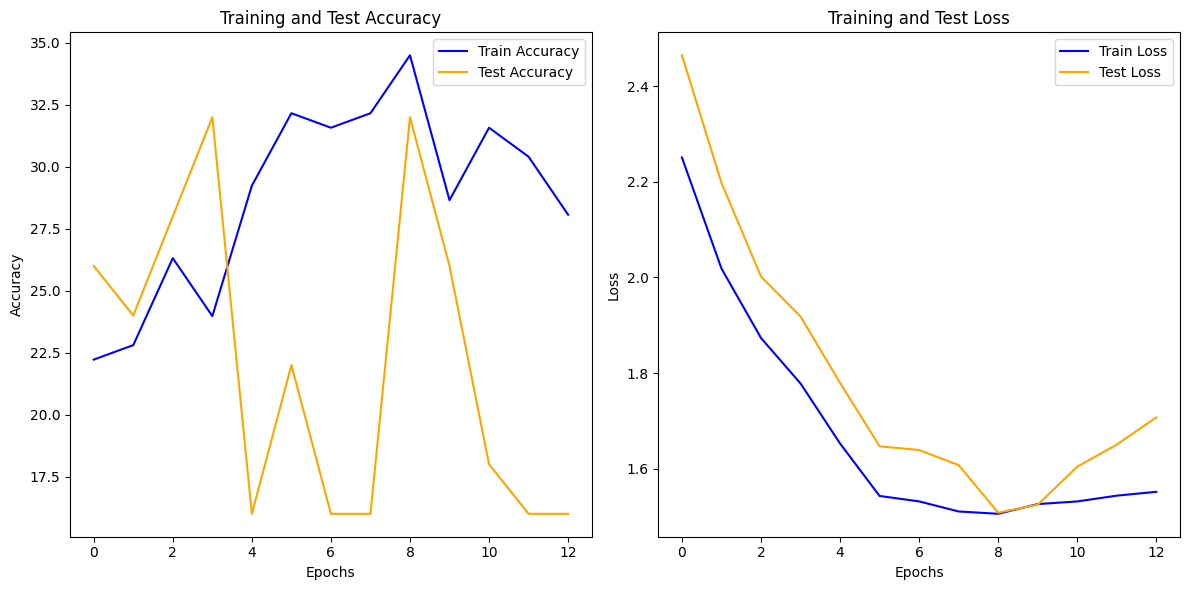

In [ ]:
epochs = list(range(len(last_epoch)))  # модель 1

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

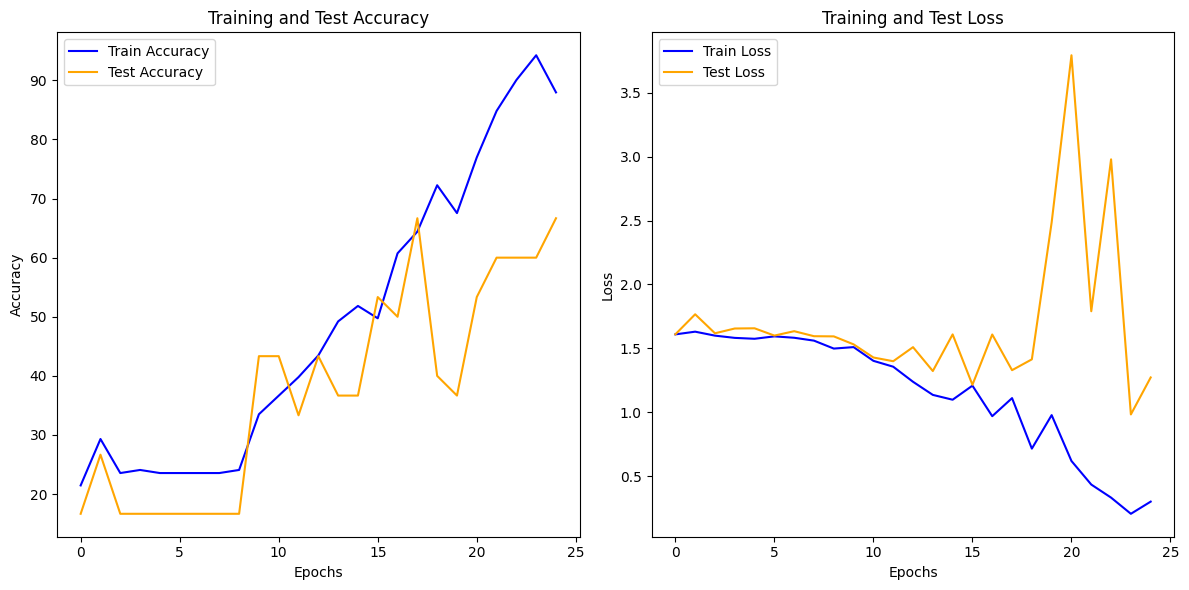

In [ ]:
epochs = list(range(len(last_epoch)))  # модель 1 в2

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()


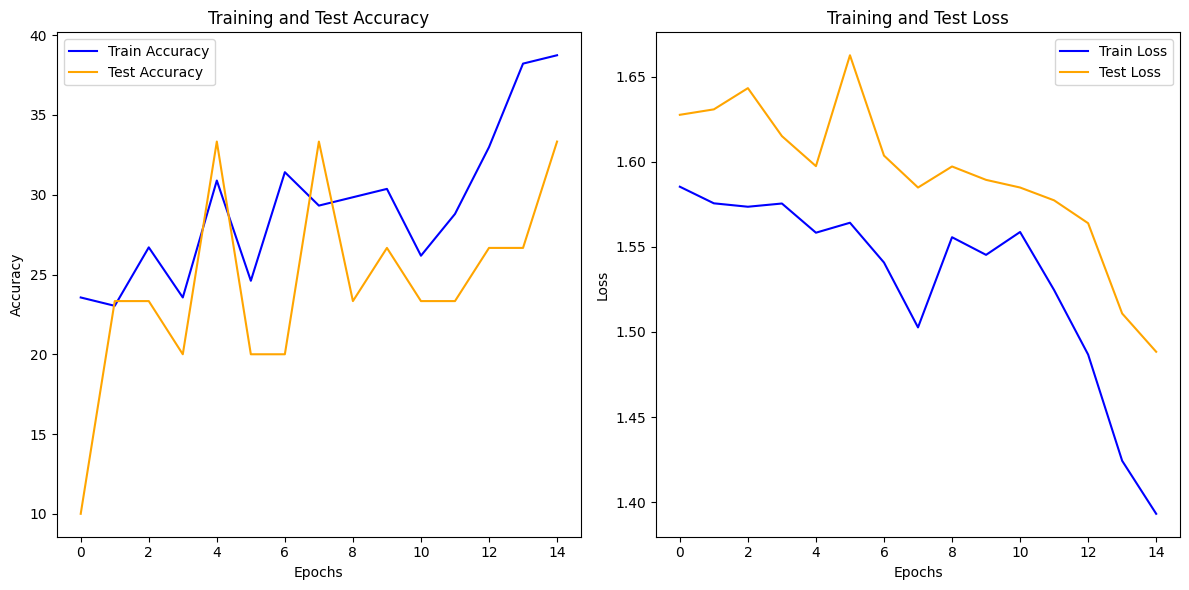

In [ ]:
epochs = list(range(len(last_epoch)))  # модель 1 в1

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

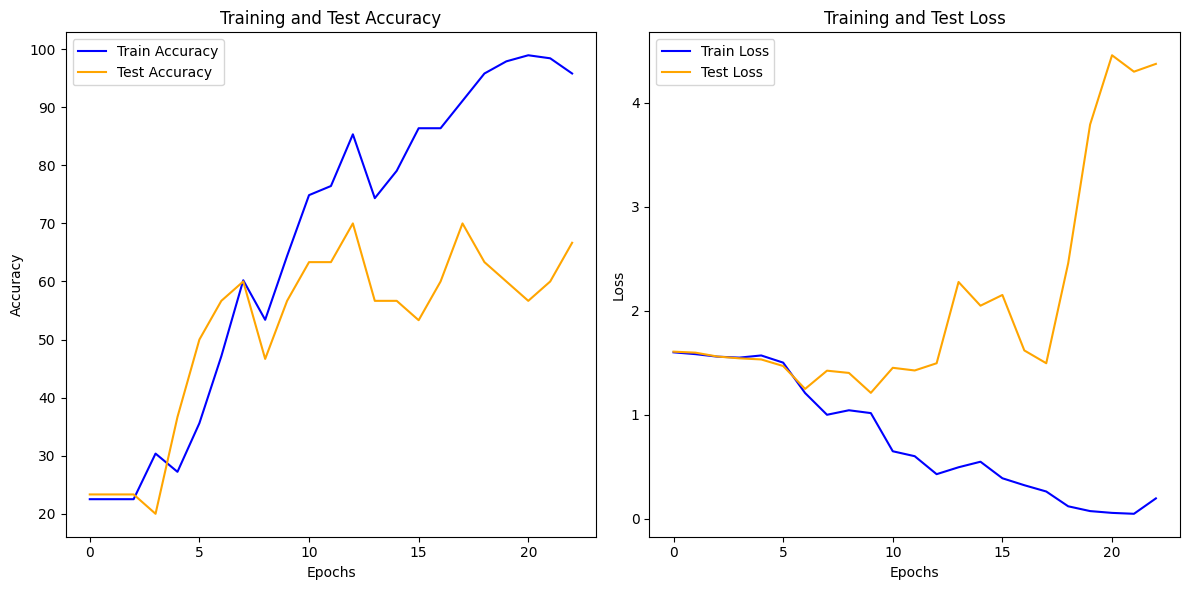

In [ ]:
epochs = list(range(len(last_epoch)))  # модель 2 в3

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

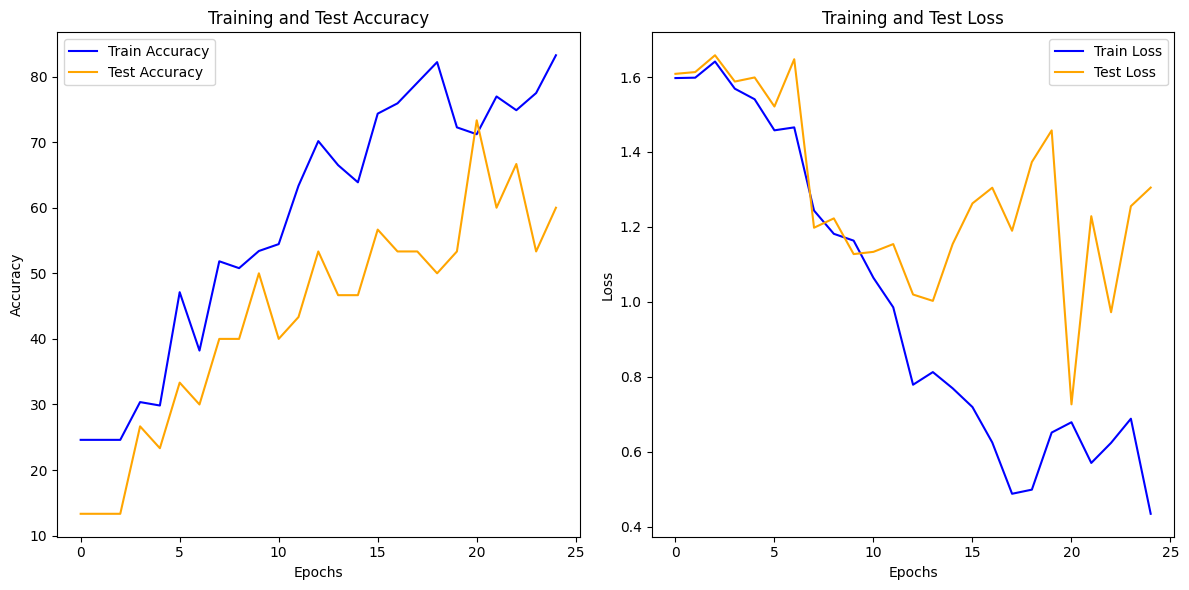

In [ ]:
epochs = list(range(len(last_epoch)))  # модель 2 в4

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

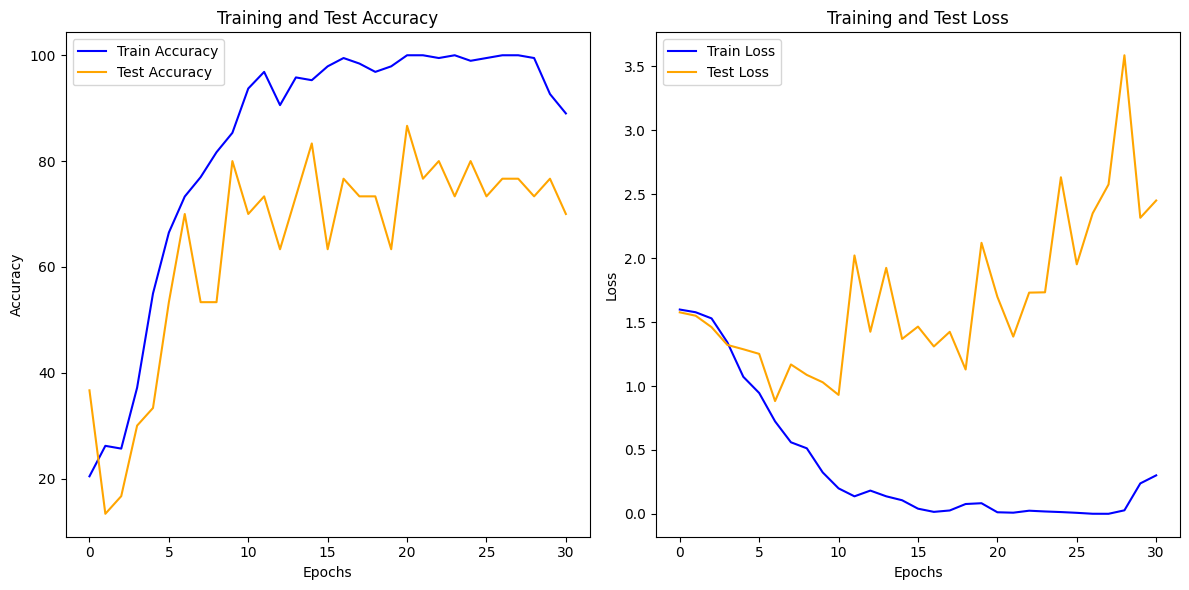

In [ ]:
epochs = list(range(len(last_epoch)))  # модель 3

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

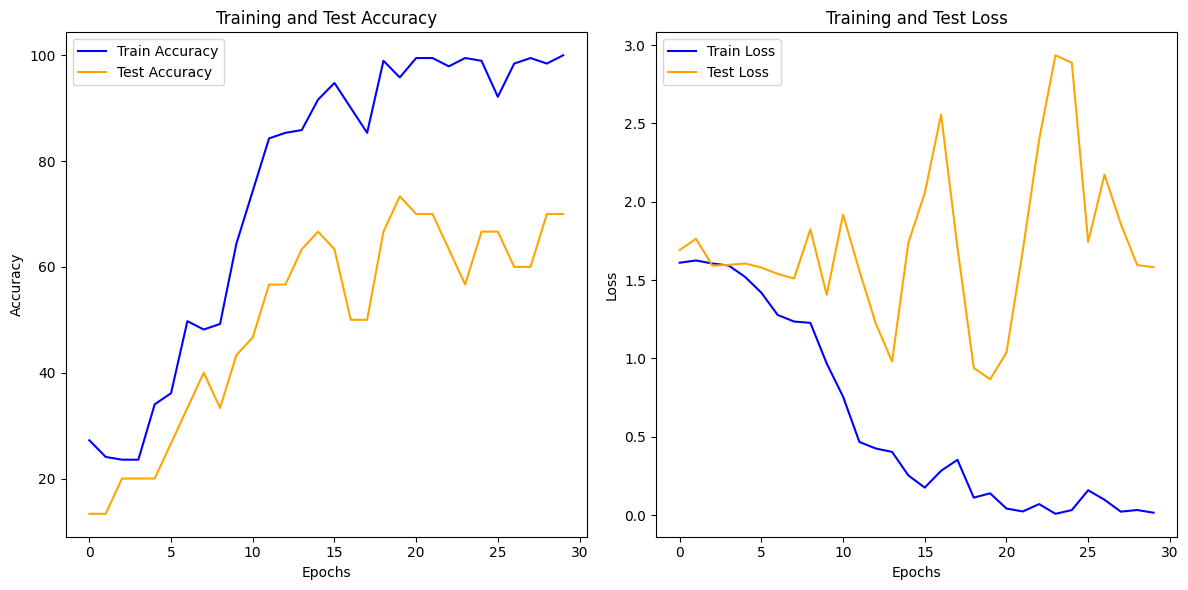

In [ ]:
epochs = list(range(len(last_epoch)))  # модель 4

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

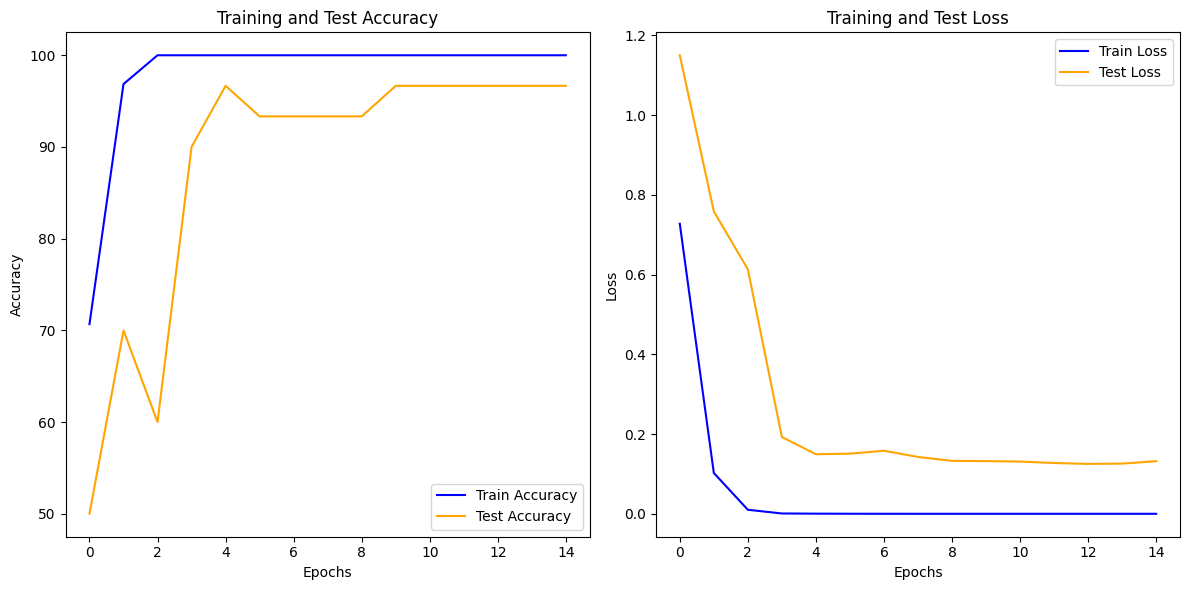

In [ ]:
epochs = list(range(len(last_epoch)))  # модель 5000

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

In [ ]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))

<All keys matched successfully>

In [ ]:
def get_preds(model, loader, device):
  model.eval()
  y_true = torch.tensor([], dtype=torch.long, device=device)
  all_outputs = torch.tensor([], device=device)

  with torch.no_grad():
      for data in test_loader:
          inputs = [i.to(device) for i in data[:-1]]
          labels = data[-1].to(device)

          outputs = model(*inputs)
          y_true = torch.cat((y_true, labels), 0)
          all_outputs = torch.cat((all_outputs, outputs), 0)

      y_true = y_true.cpu().numpy()
      _, y_pred = torch.max(all_outputs, 1)
      y_pred = y_pred.cpu().numpy()
      y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()

  return y_true, y_pred, y_pred_prob

In [ ]:
y_true, y_pred, _ = get_preds(model, test_loader, device)

In [ ]:
from sklearn.metrics import matthews_corrcoef, classification_report

In [ ]:
print(classification_report(y_true, y_pred, target_names=dataset.classes)) # модель 1

              precision    recall  f1-score   support

      Daphne       0.29      0.29      0.29         7
        Fred       0.30      0.87      0.45        15
      Scooby       0.00      0.00      0.00         7
      Shaggy       0.00      0.00      0.00        13
       Velma       0.00      0.00      0.00         8

    accuracy                           0.30        50
   macro avg       0.12      0.23      0.15        50
weighted avg       0.13      0.30      0.17        50



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(classification_report(y_true, y_pred, target_names=dataset.classes)) # модель 2 в1

              precision    recall  f1-score   support

      Daphne       0.00      0.00      0.00         8
        Fred       0.00      0.00      0.00         4
      Scooby       0.31      0.80      0.44         5
      Shaggy       0.29      0.83      0.43         6
       Velma       0.00      0.00      0.00         7

    accuracy                           0.30        30
   macro avg       0.12      0.33      0.18        30
weighted avg       0.11      0.30      0.16        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(classification_report(y_true, y_pred, target_names=dataset.classes)) # модель 2 в2

              precision    recall  f1-score   support

      Daphne       0.75      0.50      0.60         6
        Fred       0.80      0.80      0.80         5
      Scooby       0.56      1.00      0.72         9
      Shaggy       0.80      0.80      0.80         5
       Velma       0.00      0.00      0.00         5

    accuracy                           0.67        30
   macro avg       0.58      0.62      0.58        30
weighted avg       0.59      0.67      0.60        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(classification_report(y_true, y_pred, target_names=dataset.classes)) # модель 2 в4

              precision    recall  f1-score   support

      Daphne       0.89      1.00      0.94         8
        Fred       1.00      1.00      1.00         8
      Scooby       0.60      0.50      0.55         6
      Shaggy       0.29      0.50      0.36         4
       Velma       1.00      0.25      0.40         4

    accuracy                           0.73        30
   macro avg       0.75      0.65      0.65        30
weighted avg       0.80      0.73      0.73        30



In [ ]:
print(classification_report(y_true, y_pred, target_names=dataset.classes)) # модель 3

              precision    recall  f1-score   support

      Daphne       1.00      0.82      0.90        11
        Fred       1.00      0.75      0.86         4
      Scooby       1.00      0.83      0.91         6
      Shaggy       0.89      1.00      0.94         8
       Velma       0.25      1.00      0.40         1

    accuracy                           0.87        30
   macro avg       0.83      0.88      0.80        30
weighted avg       0.95      0.87      0.89        30



In [ ]:
print(classification_report(y_true, y_pred, target_names=dataset.classes)) # модель 4

              precision    recall  f1-score   support

      Daphne       0.70      0.78      0.74         9
        Fred       0.75      0.75      0.75         4
      Scooby       0.83      0.71      0.77         7
      Shaggy       0.62      0.83      0.71         6
       Velma       1.00      0.50      0.67         4

    accuracy                           0.73        30
   macro avg       0.78      0.72      0.73        30
weighted avg       0.76      0.73      0.73        30



In [ ]:
print(classification_report(y_true, y_pred, target_names=dataset.classes)) # модель 5000

              precision    recall  f1-score   support

      Daphne       1.00      0.89      0.94         9
        Fred       0.75      1.00      0.86         3
      Scooby       1.00      1.00      1.00         5
      Shaggy       1.00      1.00      1.00         9
       Velma       1.00      1.00      1.00         4

    accuracy                           0.97        30
   macro avg       0.95      0.98      0.96        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
! pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 21.3 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model=YOLO("yolov8n-cls.pt")

100%|██████████| 5.31M/5.31M [00:00<00:00, 92.6MB/s]


In [ ]:
model.to(device)

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
from torchvision import models

model = models.resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.4MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

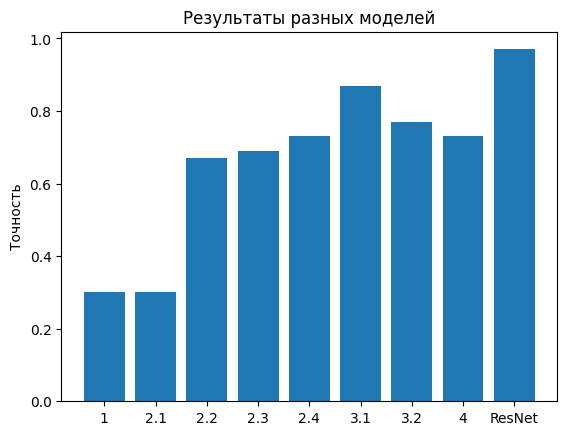

In [ ]:
import matplotlib.pyplot as plt

# Пример данных
цифры = ["1", "2.1", "2.2", "2.3", "2.4", "3.1", "3.2", "4", "ResNet"]
значения = [0.3, 0.3, 0.67, 0.69, 0.73, 0.87, 0.77, 0.73, 0.97]

# Построение столбчатой диаграммы
plt.bar(цифры, значения)

# Добавление заголовка и меток
plt.title("Результаты разных моделей")

plt.ylabel("Точность")

# Показать диаграмму
plt.show()